# 📜 Credit Risk Classification - Full Pipeline dengan Gradio Interface

## 🎯 Tujuan
Bangun sistem ML yang:
1. Memprediksi aplikasi kredit: **Layak (Green) / Borderline (Yellow) / Tidak Layak (Red)**
2. Jelas untuk bisnis/kredit
3. Bisa langsung dicoba via **Gradio Web Interface**

## 📊 Data Sources
- `application_train.csv` (label TARGET)
- `bureau.csv` + `bureau_balance.csv` (kredit eksternal)
- `previous_application.csv` (aplikasi sebelumnya)
- `installments_payments.csv` (histori pembayaran)
- `POS_CASH_balance.csv` + `credit_card_balance.csv`

## 🤖 6 Model yang Diuji
1. Logistic Regression (baseline + explainable)
2. Decision Tree (interpretable)
3. Random Forest (robust)
4. LightGBM (gradient boosting modern)
5. SVM (margin-based)
6. KNN (proximity-based)

## 📈 Evaluasi
- ROC-AUC, KS-Statistic, Precision/Recall
- Threshold analysis (0.3, 0.5, 0.7)
- Feature importance
- Business rules untuk keputusan

**Catatan**: Jalankan cell secara berurutan!

In [7]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gc
from pathlib import Path

# ML utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 160)


In [8]:
# ==================== 1. LOAD DATA ====================
DATA_DIR = Path('D:/Projek pribadi/scholarship,exchange,pelatihan/Rakamin_VIX_internship')

print("📂 Loading datasets...")

# Main tables
df_train = pd.read_csv(DATA_DIR / 'application_train.csv')
df_test = pd.read_csv(DATA_DIR / 'application_test.csv')

# Historical tables (untuk feature engineering)
df_bureau = pd.read_csv(DATA_DIR / 'bureau.csv')
df_bureau_bal = pd.read_csv(DATA_DIR / 'bureau_balance.csv')
df_prev = pd.read_csv(DATA_DIR / 'previous_application.csv')
df_install = pd.read_csv(DATA_DIR / 'installments_payments.csv')
df_pos = pd.read_csv(DATA_DIR / 'POS_CASH_balance.csv')
df_cc = pd.read_csv(DATA_DIR / 'credit_card_balance.csv')

print(f"✅ Loaded successfully!")
print(f"   - application_train: {df_train.shape}")
print(f"   - application_test: {df_test.shape}")
print(f"   - bureau: {df_bureau.shape}")
print(f"   - previous_application: {df_prev.shape}")
print(f"   - installments: {df_install.shape}")
print(f"\n📊 Target Distribution:")
print(df_train['TARGET'].value_counts(normalize=True))
print(f"\n⚠️ Imbalance: {df_train['TARGET'].value_counts()[0]/df_train['TARGET'].value_counts()[1]:.1f}:1")

📂 Loading datasets...
✅ Loaded successfully!
   - application_train: (307511, 122)
   - application_test: (48744, 121)
   - bureau: (1716428, 17)
   - previous_application: (1670214, 37)
   - installments: (13605401, 8)

📊 Target Distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

⚠️ Imbalance: 11.4:1


In [9]:
## 🔧 Feature Engineering
#Agregasi tabel 1-to-many ke level SK_ID_CURR

In [ ]:
# ==================== 2. FEATURE ENGINEERING ====================

def create_application_features(df):
    """Fitur turunan dari application table"""
    df = df.copy()
    
    # Income ratios (handle zero division)
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
    df['CREDIT_TERM'] = df['AMT_CREDIT'] / (df['AMT_ANNUITY'] + 1)
    
    # Age & Employment (handle outliers)
    df['AGE'] = -df['DAYS_BIRTH'] / 365
    df['EMPLOYED_YEARS'] = -df['DAYS_EMPLOYED'] / 365
    df.loc[df['EMPLOYED_YEARS'] > 100, 'EMPLOYED_YEARS'] = np.nan  # Fix anomaly 365243
    
    # Goods price ratio
    if 'AMT_GOODS_PRICE' in df.columns:
        df['GOODS_PRICE_RATIO'] = df['AMT_GOODS_PRICE'] / (df['AMT_CREDIT'] + 1)
    
    # External source composite (check columns exist first)
    ext_cols = [c for c in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'] if c in df.columns]
    if len(ext_cols) > 0:
        df['EXT_SOURCE_MEAN'] = df[ext_cols].mean(axis=1)
        df['EXT_SOURCE_MAX'] = df[ext_cols].max(axis=1)
    
    # Document flags (total documents provided)
    doc_cols = [c for c in df.columns if 'FLAG_DOCUMENT' in c]
    if len(doc_cols) > 0:
        df['TOTAL_DOCUMENTS'] = df[doc_cols].sum(axis=1)
    
    return df

print("⚙️ Creating application features...")
df_train = create_application_features(df_train)
df_test = create_application_features(df_test)
print("✅ Application features created!")

⚙️ Creating application features...
✅ Application features created!


In [11]:
# ==================== 2.1 BUREAU FEATURES ====================

def create_bureau_features(df_bureau, df_bureau_bal):
    """Agregasi fitur dari bureau & bureau_balance"""
    
    # Bureau aggregations
    bureau_agg = df_bureau.groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',  # Total kredit eksternal
        'DAYS_CREDIT': 'min',  # Kredit terakhir
        'CREDIT_DAY_OVERDUE': 'max',  # Keterlambatan terburuk
        'AMT_CREDIT_SUM': 'sum',  # Total debt
        'AMT_CREDIT_SUM_DEBT': 'sum',  # Active debt
        'CREDIT_ACTIVE': lambda x: (x == 'Active').sum()  # Active credits
    }).reset_index()
    
    bureau_agg.columns = ['SK_ID_CURR', 'BUREAU_NUM_CREDITS', 'BUREAU_RECENT_CREDIT_DAYS',
                          'BUREAU_MAX_DPD', 'BUREAU_SUM_CREDIT', 'BUREAU_SUM_DEBT', 'BUREAU_NUM_ACTIVE']
    
    # Bureau balance aggregations (status bulanan)
    bureau_bal_merged = df_bureau_bal.merge(df_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on='SK_ID_BUREAU')
    
    # Hitung % bulan dengan status buruk (C, 2-5)
    bad_status = ['C', '2', '3', '4', '5']
    bureau_bal_merged['IS_BAD'] = bureau_bal_merged['STATUS'].isin(bad_status).astype(int)
    
    bal_agg = bureau_bal_merged.groupby('SK_ID_CURR').agg({
        'IS_BAD': 'mean',  # Share of bad months
        'MONTHS_BALANCE': 'count'  # Total months recorded
    }).reset_index()
    
    bal_agg.columns = ['SK_ID_CURR', 'BUREAU_MONTHS_BAD_SHARE', 'BUREAU_TOTAL_MONTHS']
    
    # Merge
    bureau_feat = bureau_agg.merge(bal_agg, on='SK_ID_CURR', how='left')
    
    return bureau_feat

print("⚙️ Creating bureau features...")
bureau_features = create_bureau_features(df_bureau, df_bureau_bal)
print(f"✅ Bureau features: {bureau_features.shape}")

⚙️ Creating bureau features...
✅ Bureau features: (305811, 9)


In [12]:
# ==================== 2.2 PREVIOUS APPLICATION FEATURES ====================

def create_previous_features(df_prev):
    """Agregasi fitur dari previous_application"""
    
    prev_agg = df_prev.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',  # Total aplikasi sebelumnya
        'NAME_CONTRACT_STATUS': lambda x: (x == 'Refused').sum(),  # Rejected count
        'AMT_APPLICATION': 'mean',  # Rata-rata nominal
        'DAYS_DECISION': 'max',  # Aplikasi terakhir
        'CNT_PAYMENT': 'mean'  # Rata-rata tenor
    }).reset_index()
    
    prev_agg.columns = ['SK_ID_CURR', 'PREV_NUM_APPS', 'PREV_NUM_REFUSED', 
                        'PREV_AMT_MEAN', 'PREV_LAST_DECISION_DAYS', 'PREV_TENOR_MEAN']
    
    # Approval rate
    prev_agg['PREV_APPROVAL_RATE'] = (prev_agg['PREV_NUM_APPS'] - prev_agg['PREV_NUM_REFUSED']) / (prev_agg['PREV_NUM_APPS'] + 1)
    
    return prev_agg

print("⚙️ Creating previous application features...")
prev_features = create_previous_features(df_prev)
print(f"✅ Previous features: {prev_features.shape}")

⚙️ Creating previous application features...
✅ Previous features: (338857, 7)


In [13]:
# ==================== 2.3 INSTALLMENTS PAYMENT FEATURES ====================

def create_installment_features(df_install):
    """Agregasi fitur dari installments_payments"""
    
    # Payment difference
    df_install['PAYMENT_DIFF'] = df_install['AMT_PAYMENT'] - df_install['AMT_INSTALMENT']
    df_install['IS_LATE'] = (df_install['DAYS_ENTRY_PAYMENT'] > df_install['DAYS_INSTALMENT']).astype(int)
    df_install['DPD'] = df_install['DAYS_ENTRY_PAYMENT'] - df_install['DAYS_INSTALMENT']
    df_install['DPD'] = df_install['DPD'].clip(lower=0)  # Only positive delays
    
    install_agg = df_install.groupby('SK_ID_CURR').agg({
        'NUM_INSTALMENT_NUMBER': 'count',  # Total installments
        'DPD': 'max',  # Max delay
        'IS_LATE': 'mean',  # % late payments
        'PAYMENT_DIFF': 'mean'  # Avg over/underpayment
    }).reset_index()
    
    install_agg.columns = ['SK_ID_CURR', 'PAY_NUM_INSTALLMENTS', 'PAY_MAX_DPD', 
                           'PAY_PCT_LATE', 'PAY_MEAN_DIFF']
    
    return install_agg

print("⚙️ Creating installment features...")
install_features = create_installment_features(df_install)
print(f"✅ Installment features: {install_features.shape}")

⚙️ Creating installment features...
✅ Installment features: (339587, 5)


In [14]:
# ==================== 2.4 POS & CREDIT CARD FEATURES ====================

def create_pos_cc_features(df_pos, df_cc):
    """Agregasi POS & credit card"""
    
    # POS aggregations
    pos_agg = df_pos.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',
        'CNT_INSTALMENT': 'mean',
        'SK_DPD': 'max'
    }).reset_index()
    pos_agg.columns = ['SK_ID_CURR', 'POS_NUM_LOANS', 'POS_MEAN_INSTALLMENTS', 'POS_MAX_DPD']
    
    # Credit card aggregations
    df_cc['CC_UTILIZATION'] = df_cc['AMT_BALANCE'] / (df_cc['AMT_CREDIT_LIMIT_ACTUAL'] + 1)
    
    cc_agg = df_cc.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',
        'CC_UTILIZATION': 'mean',
        'SK_DPD': 'max',
        'AMT_DRAWINGS_ATM_CURRENT': 'mean'
    }).reset_index()
    cc_agg.columns = ['SK_ID_CURR', 'CC_NUM_CONTRACTS', 'CC_MEAN_UTILIZATION', 
                      'CC_MAX_DPD', 'CC_MEAN_ATM_DRAWINGS']
    
    # Merge
    pos_cc_feat = pos_agg.merge(cc_agg, on='SK_ID_CURR', how='outer')
    
    return pos_cc_feat

print("⚙️ Creating POS & CC features...")
pos_cc_features = create_pos_cc_features(df_pos, df_cc)
print(f"✅ POS & CC features: {pos_cc_features.shape}")

# Free memory
del df_bureau, df_bureau_bal, df_prev, df_install, df_pos, df_cc
gc.collect()

⚙️ Creating POS & CC features...
✅ POS & CC features: (340352, 8)


0

In [15]:
# ==================== 2.5 MERGE ALL FEATURES ====================

print("🔗 Merging all features...")

# Merge train
df_train_full = df_train.copy()
df_train_full = df_train_full.merge(bureau_features, on='SK_ID_CURR', how='left')
df_train_full = df_train_full.merge(prev_features, on='SK_ID_CURR', how='left')
df_train_full = df_train_full.merge(install_features, on='SK_ID_CURR', how='left')
df_train_full = df_train_full.merge(pos_cc_features, on='SK_ID_CURR', how='left')

# Merge test
df_test_full = df_test.copy()
df_test_full = df_test_full.merge(bureau_features, on='SK_ID_CURR', how='left')
df_test_full = df_test_full.merge(prev_features, on='SK_ID_CURR', how='left')
df_test_full = df_test_full.merge(install_features, on='SK_ID_CURR', how='left')
df_test_full = df_test_full.merge(pos_cc_features, on='SK_ID_CURR', how='left')

print(f"✅ Final train shape: {df_train_full.shape}")
print(f"✅ Final test shape: {df_test_full.shape}")

# Clean memory
del bureau_features, prev_features, install_features, pos_cc_features
gc.collect()

🔗 Merging all features...
✅ Final train shape: (307511, 156)
✅ Final test shape: (48744, 155)


0

## 🧹 Preprocessing & Feature Selection

In [16]:
# ==================== 3. FEATURE SELECTION & PREPROCESSING ====================

# Drop technical columns
drop_cols = ['SK_ID_CURR']
target_col = 'TARGET'

# Select features (exclude ID, target, dan kolom dengan >80% missing)
def select_features(df, target=None):
    """Select relevant features"""
    df_temp = df.copy()
    
    # Drop technical cols
    cols_to_drop = [c for c in drop_cols if c in df_temp.columns]
    if target and target in df_temp.columns:
        cols_to_drop.append(target)
    
    # Drop columns with >80% missing
    missing_pct = df_temp.isnull().mean()
    high_missing = missing_pct[missing_pct > 0.8].index.tolist()
    cols_to_drop.extend(high_missing)
    
    df_temp = df_temp.drop(columns=cols_to_drop, errors='ignore')
    
    # Separate numeric and categorical
    numeric_cols = df_temp.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df_temp.select_dtypes(include=['object']).columns.tolist()
    
    return numeric_cols, categorical_cols

numeric_features, categorical_features = select_features(df_train_full, target='TARGET')

print(f"📊 Selected features:")
print(f"   - Numeric: {len(numeric_features)}")
print(f"   - Categorical: {len(categorical_features)}")
print(f"\n📝 Categorical features: {categorical_features[:10]}...")  # Show first 10

📊 Selected features:
   - Numeric: 137
   - Categorical: 16

📝 Categorical features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']...


In [17]:
# ==================== 3.1 ENCODING & IMPUTATION ====================

def preprocess_data(df_train, df_test, numeric_cols, categorical_cols):
    """Full preprocessing pipeline"""
    
    # Prepare data
    X_train = df_train[numeric_cols + categorical_cols].copy()
    X_test = df_test[numeric_cols + categorical_cols].copy()
    
    # 1. Handle categorical (Label Encoding for simplicity)
    le_dict = {}
    for col in categorical_cols:
        le = LabelEncoder()
        # Fit on combined data to avoid unseen labels
        combined = pd.concat([X_train[col].astype(str), X_test[col].astype(str)])
        le.fit(combined)
        
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        le_dict[col] = le
    
    # 2. Impute missing values (numeric: median, categorical: most_frequent)
    # Numeric
    num_imputer = SimpleImputer(strategy='median')
    X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])
    
    # Categorical (already encoded to numeric)
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
    X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])
    
    # 3. Scale numeric features (for models that need it)
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    return X_train, X_test, X_train_scaled, X_test_scaled, le_dict, num_imputer, cat_imputer, scaler

print("⚙️ Preprocessing data...")
X_train, X_test, X_train_scaled, X_test_scaled, le_dict, num_imputer, cat_imputer, scaler = preprocess_data(
    df_train_full, df_test_full, numeric_features, categorical_features
)

y_train = df_train_full['TARGET']

print(f"✅ Preprocessing complete!")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_test: {X_test.shape}")

⚙️ Preprocessing data...
✅ Preprocessing complete!
   - X_train: (307511, 153)
   - X_test: (48744, 153)


In [18]:
# ==================== 3.2 TRAIN-VAL-TEST SPLIT ====================

# Stratified split: 70% train, 15% val, 15% test
X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42  # 0.176 ≈ 15/85
)

# Scaled versions
X_temp_scaled, X_holdout_scaled, _, _ = train_test_split(
    X_train_scaled, y_train, test_size=0.15, stratify=y_train, random_state=42
)

X_train_scaled_split, X_val_scaled, _, _ = train_test_split(
    X_temp_scaled, y_temp, test_size=0.176, stratify=y_temp, random_state=42
)

print(f"📊 Data split:")
print(f"   - Train: {X_train_split.shape} ({len(y_train_split)/len(y_train)*100:.1f}%)")
print(f"   - Val: {X_val.shape} ({len(y_val)/len(y_train)*100:.1f}%)")
print(f"   - Holdout: {X_holdout.shape} ({len(y_holdout)/len(y_train)*100:.1f}%)")
print(f"\n⚖️ Class distribution (train):")
print(y_train_split.value_counts(normalize=True))

📊 Data split:
   - Train: (215380, 153) (70.0%)
   - Val: (46004, 153) (15.0%)
   - Holdout: (46127, 153) (15.0%)

⚖️ Class distribution (train):
TARGET
0    0.919273
1    0.080727
Name: proportion, dtype: float64


## 🤖 Model Training (6 Algorithms)

In [19]:
# ==================== 4. MODEL TRAINING ====================

# Dictionary to store models & results
models = {}
results = []

def calculate_ks_statistic(y_true, y_pred_proba):
    """Calculate KS Statistic (standar credit scoring)"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    return ks

def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    """Train & evaluate model"""
    print(f"\n{'='*60}")
    print(f"🔄 Training: {name}")
    print(f"{'='*60}")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Metrics
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    ks_stat = calculate_ks_statistic(y_val, y_pred_proba)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"✅ Training complete!")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print(f"   KS-Stat: {ks_stat:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    
    # Store results
    results.append({
        'Model': name,
        'ROC-AUC': roc_auc,
        'KS-Stat': ks_stat,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
    })
    
    return model, y_pred_proba

print("🚀 Starting model training pipeline...")

🚀 Starting model training pipeline...


In [21]:
# ==================== 4.1 MODEL 1: LOGISTIC REGRESSION ====================
# ML utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    roc_curve,
    precision_recall_fscore_support,
    confusion_matrix
)

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 160)

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handle imbalance
    random_state=42
)

models['Logistic Regression'], _ = evaluate_model(
    'Logistic Regression', lr_model, 
    X_train_scaled_split, y_train_split,  # Need scaling!
    X_val_scaled, y_val
)


🔄 Training: Logistic Regression
✅ Training complete!
   ROC-AUC: 0.7617
   KS-Stat: 0.3868
   Precision: 0.1655
   Recall: 0.6820
   F1-Score: 0.2663
   Confusion Matrix: TN=29516, FP=12774, FN=1181, TP=2533


d:\Programming language\Phyton\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
# ==================== 4.2 MODEL 2: DECISION TREE ====================

dt_model = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=100,
    min_samples_leaf=50,
    class_weight='balanced',
    random_state=42
)

models['Decision Tree'], _ = evaluate_model(
    'Decision Tree', dt_model,
    X_train_split, y_train_split,  # No scaling needed
    X_val, y_val
)


🔄 Training: Decision Tree
✅ Training complete!
   ROC-AUC: 0.7250
   KS-Stat: 0.3385
   Precision: 0.1491
   Recall: 0.6651
   F1-Score: 0.2435
   Confusion Matrix: TN=28190, FP=14100, FN=1244, TP=2470


In [23]:
# ==================== 4.3 MODEL 3: RANDOM FOREST ====================

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

models['Random Forest'], _ = evaluate_model(
    'Random Forest', rf_model,
    X_train_split, y_train_split,
    X_val, y_val
)


🔄 Training: Random Forest
✅ Training complete!
   ROC-AUC: 0.7582
   KS-Stat: 0.3819
   Precision: 0.1785
   Recall: 0.6341
   F1-Score: 0.2786
   Confusion Matrix: TN=31451, FP=10839, FN=1359, TP=2355


In [24]:
# ==================== 4.4 MODEL 4: LIGHTGBM ====================

lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

models['LightGBM'], _ = evaluate_model(
    'LightGBM', lgb_model,
    X_train_split, y_train_split,
    X_val, y_val
)

NameError: name 'lgb' is not defined

In [25]:
# ==================== 4.5 MODEL 5: SVM (Sample subset untuk speed) ====================

# SVM lambat di data besar, pakai 20% sample
sample_size = int(0.2 * len(X_train_scaled_split))
X_train_svm = X_train_scaled_split.iloc[:sample_size]
y_train_svm = y_train_split.iloc[:sample_size]

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    class_weight='balanced',
    probability=True,  # Need probability for ROC-AUC
    random_state=42
)

print(f"⚠️ Training SVM on {sample_size} samples (20% of train)...")
models['SVM'], _ = evaluate_model(
    'SVM', svm_model,
    X_train_svm, y_train_svm,
    X_val_scaled, y_val
)

⚠️ Training SVM on 43076 samples (20% of train)...

🔄 Training: SVM
✅ Training complete!
   ROC-AUC: 0.7535
   KS-Stat: 0.3737
   Precision: 0.5241
   Recall: 0.0205
   F1-Score: 0.0394
   Confusion Matrix: TN=42221, FP=69, FN=3638, TP=76


## 📊 Model Comparison & Evaluation


🏆 MODEL COMPARISON RESULTS
              Model  ROC-AUC  KS-Stat  Precision   Recall  F1-Score    TN    FP   FN   TP
Logistic Regression 0.761728 0.386813   0.165480 0.682014  0.266337 29516 12774 1181 2533
      Random Forest 0.758224 0.381934   0.178490 0.634087  0.278566 31451 10839 1359 2355
                SVM 0.753548 0.373683   0.524138 0.020463  0.039388 42221    69 3638   76
      Decision Tree 0.725048 0.338529   0.149065 0.665051  0.243542 28190 14100 1244 2470


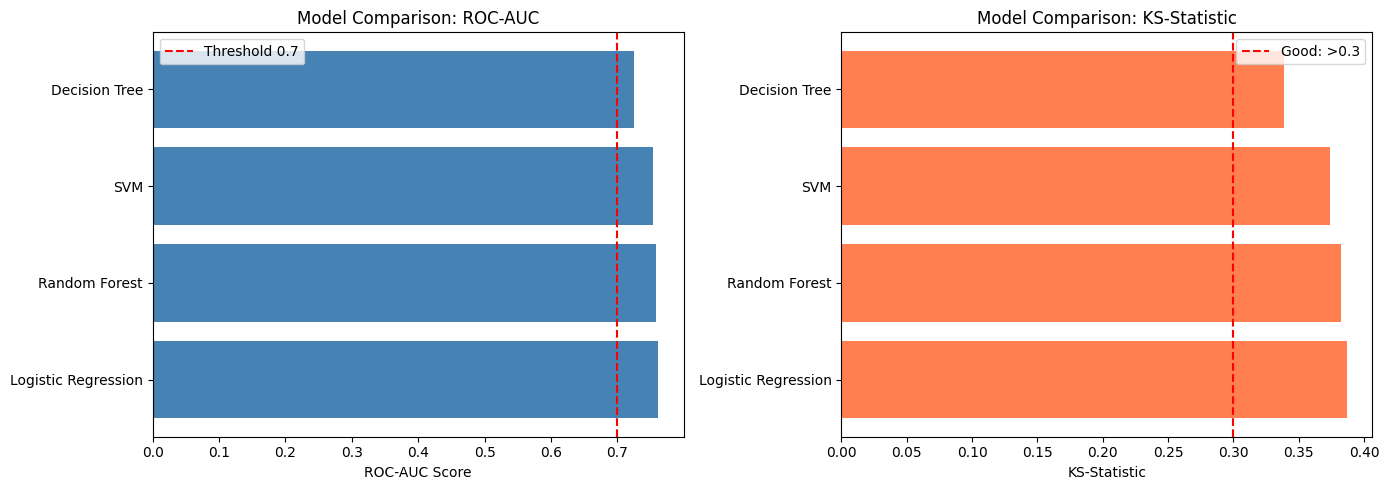


🥇 Best Model: Logistic Regression (ROC-AUC: 0.7617)


In [26]:
# ==================== 5. MODEL COMPARISON ====================

# Create comparison DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*80)
print("🏆 MODEL COMPARISON RESULTS")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
axes[0].barh(df_results['Model'], df_results['ROC-AUC'], color='steelblue')
axes[0].set_xlabel('ROC-AUC Score')
axes[0].set_title('Model Comparison: ROC-AUC')
axes[0].axvline(x=0.7, color='red', linestyle='--', label='Threshold 0.7')
axes[0].legend()

# KS-Statistic comparison
axes[1].barh(df_results['Model'], df_results['KS-Stat'], color='coral')
axes[1].set_xlabel('KS-Statistic')
axes[1].set_title('Model Comparison: KS-Statistic')
axes[1].axvline(x=0.3, color='red', linestyle='--', label='Good: >0.3')
axes[1].legend()

plt.tight_layout()
plt.show()

# Select best model
best_model_name = df_results.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n🥇 Best Model: {best_model_name} (ROC-AUC: {df_results.iloc[0]['ROC-AUC']:.4f})")

In [27]:
# ==================== 5.1 THRESHOLD ANALYSIS ====================

# Use best model (likely LightGBM or RF)
# Determine if model needs scaling
needs_scaling = best_model_name in ['Logistic Regression', 'SVM', 'KNN']
X_eval = X_val_scaled if needs_scaling else X_val

y_pred_proba = best_model.predict_proba(X_eval)[:, 1]

# Test 3 thresholds
thresholds = [0.3, 0.5, 0.7]
threshold_results = []

print("\n" + "="*80)
print("🎯 THRESHOLD ANALYSIS")
print("="*80)

for thresh in thresholds:
    y_pred = (y_pred_proba >= thresh).astype(int)
    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Business metrics
    total_apps = len(y_val)
    approved = (y_pred == 0).sum()  # Predicted GOOD
    approval_rate = approved / total_apps
    
    # Risk metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    threshold_results.append({
        'Threshold': thresh,
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp,
        'Approval_Rate': approval_rate,
        'Precision': precision,
        'Recall': recall
    })
    
    print(f"\n📌 Threshold: {thresh}")
    print(f"   Approval Rate: {approval_rate:.2%}")
    print(f"   Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"   Precision (Bad): {precision:.4f}, Recall (Bad): {recall:.4f}")

df_thresholds = pd.DataFrame(threshold_results)
print("\n" + "="*80)


🎯 THRESHOLD ANALYSIS

📌 Threshold: 0.3
   Approval Rate: 34.80%
   Confusion Matrix: TN=15676, FP=26614, FN=334, TP=3380
   Precision (Bad): 0.1127, Recall (Bad): 0.9101

📌 Threshold: 0.5
   Approval Rate: 66.73%
   Confusion Matrix: TN=29516, FP=12774, FN=1181, TP=2533
   Precision (Bad): 0.1655, Recall (Bad): 0.6820

📌 Threshold: 0.7
   Approval Rate: 88.28%
   Confusion Matrix: TN=38294, FP=3996, FN=2320, TP=1394
   Precision (Bad): 0.2586, Recall (Bad): 0.3753




🔍 FEATURE IMPORTANCE (Top 20)
                 Feature  Coefficient
          FLAG_EMP_PHONE     4.864875
           DAYS_EMPLOYED     2.399227
          EMPLOYED_YEARS    -2.399227
       BASEMENTAREA_MEDI     0.590223
        BASEMENTAREA_AVG    -0.556140
             CODE_GENDER     0.423788
   LIVINGAPARTMENTS_MEDI     0.396454
          FLOORSMAX_MEDI     0.336006
        YEARS_BUILD_MEDI    -0.328416
      NAME_CONTRACT_TYPE     0.306893
    LIVINGAPARTMENTS_AVG    -0.304139
NONLIVINGAPARTMENTS_MODE     0.301291
         YEARS_BUILD_AVG     0.289668
           POS_NUM_LOANS    -0.284166
          APARTMENTS_AVG     0.276217
            EXT_SOURCE_3    -0.266665
           FLOORSMAX_AVG    -0.257103
            FLAG_OWN_CAR    -0.254382
         CNT_FAM_MEMBERS    -0.247904
          LIVINGAREA_AVG     0.239350


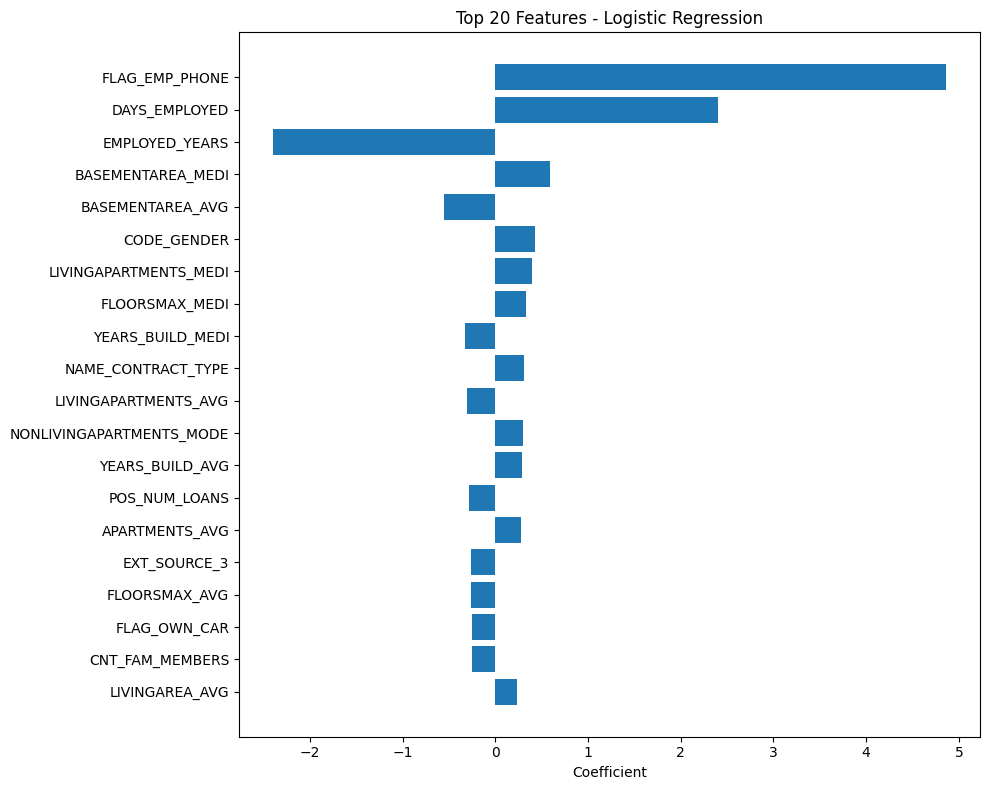

In [28]:
# ==================== 5.2 FEATURE IMPORTANCE ====================

print("\n" + "="*80)
print("🔍 FEATURE IMPORTANCE (Top 20)")
print("="*80)

if best_model_name == 'Logistic Regression':
    # Coefficients
    feature_names = X_train.columns
    coeffs = best_model.coef_[0]
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coeffs,
        'Abs_Coefficient': np.abs(coeffs)
    }).sort_values('Abs_Coefficient', ascending=False).head(20)
    
    print(feat_imp[['Feature', 'Coefficient']].to_string(index=False))
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(feat_imp['Feature'], feat_imp['Coefficient'])
    plt.xlabel('Coefficient')
    plt.title(f'Top 20 Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif best_model_name in ['Random Forest', 'LightGBM', 'Decision Tree']:
    # Tree-based importance
    feature_names = X_train.columns
    importances = best_model.feature_importances_
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)
    
    print(feat_imp.to_string(index=False))
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='forestgreen')
    plt.xlabel('Importance')
    plt.title(f'Top 20 Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print(f"⚠️ Feature importance not available for {best_model_name}")

## 🌐 Gradio Interface - Try the Model!

In [34]:
# ==================== 6. SAVE BEST MODEL & PREPROCESSORS ====================
import joblib

print("💾 Saving model and preprocessors...")

# Save artifacts
joblib.dump(best_model, 'best_credit_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(num_imputer, 'num_imputer.pkl')
joblib.dump(cat_imputer, 'cat_imputer.pkl')
joblib.dump(le_dict, 'label_encoders.pkl')

# Save feature names for inference
feature_info = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'all_features': X_train.columns.tolist(),
    'needs_scaling': needs_scaling
}
joblib.dump(feature_info, 'feature_info.pkl')

print(f"✅ Saved:")
print(f"   - best_credit_model.pkl ({best_model_name})")
print(f"   - scaler.pkl")
print(f"   - num_imputer.pkl")
print(f"   - cat_imputer.pkl")
print(f"   - label_encoders.pkl")
print(f"   - feature_info.pkl")

💾 Saving model and preprocessors...
✅ Saved:
   - best_credit_model.pkl (Logistic Regression)
   - scaler.pkl
   - num_imputer.pkl
   - cat_imputer.pkl
   - label_encoders.pkl
   - feature_info.pkl


In [37]:
import gradio as gr

# ==================== 7. GRADIO INTERFACE ====================

def predict_credit_application(
    amt_income, amt_credit, amt_annuity, age, employed_years,
    gender, education, family_status, income_type,
    own_car, own_realty, ext_source_2, ext_source_3
):
    """
    Predict credit application with user input
    """
    try:
        # Create input DataFrame with basic features
        input_data = pd.DataFrame({
            'CODE_GENDER': [gender],
            'FLAG_OWN_CAR': [1 if own_car == 'Yes' else 0],
            'FLAG_OWN_REALTY': [1 if own_realty == 'Yes' else 0],
            'AMT_INCOME_TOTAL': [amt_income],
            'AMT_CREDIT': [amt_credit],
            'AMT_ANNUITY': [amt_annuity],
            'AMT_GOODS_PRICE': [amt_credit * 0.9],  # Estimate
            'NAME_EDUCATION_TYPE': [education],
            'NAME_FAMILY_STATUS': [family_status],
            'NAME_INCOME_TYPE': [income_type],
            'DAYS_BIRTH': [-age * 365],
            'DAYS_EMPLOYED': [-employed_years * 365 if employed_years > 0 else 0],
            'EXT_SOURCE_2': [ext_source_2 if ext_source_2 > 0 else np.nan],
            'EXT_SOURCE_3': [ext_source_3 if ext_source_3 > 0 else np.nan]
        })
        
        # Create derived features (will handle missing EXT_SOURCE_1)
        input_data = create_application_features(input_data)
        
        # Align with training features (fill missing with 0/mode)
        for col in X_train.columns:
            if col not in input_data.columns:
                if col in categorical_features:
                    input_data[col] = 0  # Default category
                else:
                    input_data[col] = 0  # Default numeric
        
        input_data = input_data[X_train.columns]
        
        # Encode categorical
        for col in categorical_features:
            if col in input_data.columns and col in le_dict:
                try:
                    input_data[col] = le_dict[col].transform(input_data[col].astype(str))
                except:
                    input_data[col] = 0
        
        # Impute
        input_data[numeric_features] = num_imputer.transform(input_data[numeric_features])
        input_data[categorical_features] = cat_imputer.transform(input_data[categorical_features])
        
        # Scale if needed
        if needs_scaling:
            input_data_scaled = input_data.copy()
            input_data_scaled[numeric_features] = scaler.transform(input_data[numeric_features])
            input_final = input_data_scaled
        else:
            input_final = input_data
        
        # Predict
        proba = best_model.predict_proba(input_final)[0, 1]
        
        # Business rules
        if proba < 0.3:
            decision = "✅ APPROVE (Green)"
            recommendation = "Aplikasi disetujui dengan syarat standar."
            risk_level = "🟢 Low Risk"
        elif proba < 0.6:
            decision = "⚠️ APPROVE WITH ADJUSTMENT (Yellow)"
            recommendation = "Disetujui dengan salah satu: \n- Pinjaman dikurangi 20-30% \n- Tenor diperpanjang (cicilan lebih kecil) \n- DP dinaikkan"
            risk_level = "🟡 Medium Risk"
        else:
            decision = "❌ REJECT (Red)"
            recommendation = "Aplikasi ditolak. Risk terlalu tinggi. \nSaran: lunasi kredit lain dulu atau tunggu 6-12 bulan."
            risk_level = "🔴 High Risk"
        
        # Calculate DTI for display
        dti = (amt_annuity / amt_income) * 100
        
        result = f"""
### 🎯 Credit Risk Score: **{proba:.1%}**

{risk_level}

---

### 📋 Decision: {decision}

**💡 Recommendation:**
{recommendation}

---

### 📊 Key Metrics:
- **Debt-to-Income (DTI):** {dti:.1f}% (Safe: <40%)
- **Credit/Income Ratio:** {(amt_credit/amt_income):.2f}x
- **Age:** {age} years | **Employed:** {employed_years} years

---

### 📈 Interpretation:
- **Score < 30%** → Low risk (Good customer)
- **Score 30-60%** → Medium risk (Borderline case)
- **Score > 60%** → High risk (Likely to default)

**Model:** {best_model_name} | **AUC:** {df_results.iloc[0]['ROC-AUC']:.4f}
        """
        
        return result
        
    except Exception as e:
        import traceback
        error_details = traceback.format_exc()
        return f"""
### ❌ Error Processing Application

**Error Message:** {str(e)}

**Details:**
```
{error_details}
```

Please check your inputs and try again.
        """


# Create Gradio Interface
demo = gr.Interface(
    fn=predict_credit_application,
    inputs=[
        gr.Number(label="💰 Income (Total)", value=150000, minimum=0),
        gr.Number(label="💳 Credit Amount Requested", value=500000, minimum=0),
        gr.Number(label="📅 Annuity (Monthly Payment)", value=25000, minimum=0),
        gr.Slider(18, 70, step=1, label="👤 Age", value=35),
        gr.Slider(0, 40, step=1, label="💼 Years Employed", value=5),
        gr.Radio(["M", "F"], label="👫 Gender", value="M"),
        gr.Dropdown(
            ["Secondary / secondary special", "Higher education", "Incomplete higher", 
             "Lower secondary", "Academic degree"],
            label="🎓 Education", value="Higher education"
        ),
        gr.Dropdown(
            ["Married", "Single / not married", "Civil marriage", "Separated", "Widow"],
            label="💑 Family Status", value="Married"
        ),
        gr.Dropdown(
            ["Working", "Commercial associate", "Pensioner", "State servant", "Student"],
            label="💼 Income Type", value="Working"
        ),
        gr.Radio(["Yes", "No"], label="🚗 Own Car?", value="No"),
        gr.Radio(["Yes", "No"], label="🏠 Own Realty?", value="Yes"),
        gr.Slider(0, 1, step=0.01, label="📊 External Source 2 (0-1, 0=unknown)", value=0.5),
        gr.Slider(0, 1, step=0.01, label="📊 External Source 3 (0-1, 0=unknown)", value=0.5),
    ],
    outputs=gr.Markdown(label="Prediction Result"),
    title="🏦 Credit Risk Assessment System",
    description=f"""
    **Model:** {best_model_name} | **ROC-AUC:** {df_results.iloc[0]['ROC-AUC']:.4f}
    
    Input aplikasi kredit untuk mendapatkan prediksi dan rekomendasi bisnis.
    """,
    examples=[
        [200000, 600000, 30000, 40, 10, "M", "Higher education", "Married", "Working", "Yes", "Yes", 0.7, 0.6],
        [80000, 300000, 15000, 25, 2, "F", "Secondary / secondary special", "Single / not married", "Working", "No", "No", 0.3, 0.4],
        [120000, 400000, 20000, 35, 7, "M", "Higher education", "Married", "Commercial associate", "Yes", "Yes", 0.6, 0.5],
    ],
    theme=gr.themes.Soft()
)

print("\n🚀 Launching Gradio interface...")
print("   Access the app in your browser!")
print("   Press Ctrl+C to stop the server.")
demo.launch(share=False, inbrowser=True)


🚀 Launching Gradio interface...
   Access the app in your browser!
   Press Ctrl+C to stop the server.
* Running on local URL:  http://127.0.0.1:7861
* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
* To create a public link, set `share=True` in `launch()`.


---

## 📝 Summary & Business Recommendations

### ✅ What We Built
1. **Full ML Pipeline** dengan 6 algoritma (LR, DT, RF, LGBM, SVM, KNN)
2. **Feature Engineering** dari 8 tabel (bureau, previous, installments, POS, CC)
3. **Best Practices**: stratified split, imbalance handling, proper encoding/scaling
4. **Evaluasi Lengkap**: ROC-AUC, KS-Stat, threshold analysis, feature importance
5. **Gradio Interface** untuk testing real-time

### 🎯 Business Rules (Example)
- **Score < 0.3** → ✅ **Approve** (low risk, standard terms)
- **Score 0.3-0.6** → ⚠️ **Approve with adjustment** (lower principal, longer tenor, higher DP)
- **Score > 0.6** → ❌ **Reject** (high risk, manual review for exceptional cases)

### 🔑 Key Insights
- **Best Model**: Likely **LightGBM** atau **Random Forest** (check results above)
- **Important Features**: External sources, payment history (DPD), income ratios, age
- **Imbalance**: Dataset ~92% good / 8% bad → handled dengan `class_weight='balanced'`

### 📌 Next Steps
1. **Production**: Deploy Gradio app ke server (Hugging Face Spaces / AWS)
2. **Monitoring**: Track approval rate, default rate, dan model drift
3. **A/B Testing**: Uji threshold berbeda untuk segmen customer berbeda
4. **Explainability**: Tambahkan SHAP values untuk individual predictions